## Clasificación de dígitos usando Redes Convolucionales y Keras  

### 1 - El set de datos

En este tutorial implementaremos una red convolucional capaz de clasificar los dígitos del 0 al 9. Para ello usaremos el set de datos [MNIST](http://yann.lecun.com/exdb/mnist/), que contiene un total de 70.000 imágenes escritas a mano por diferentes personas.

![Algunos ejemplos de imágenes provenientes del set MNIST](MNIST_ejemplo.png)

Al final de este tutorial tendremos claro:
1. Cómo funciona [LeNet-5](http://yann.lecun.com/exdb/lenet/), la red convolucional usada en este tutorial
2. Cómo implementar esta red convolucional usando la librería Keras
3. Cómo evaluar el desempeño de la red

En primer lugar, veamos cómo es LeNet-5.

## 2 - LeNet-5  

Esta red es la precursora de todas las redes convolucionales usadas en la actualidad. Fue diseñada por [Yann LeCun] a finales de los años 90, con el fin de clasificar digitos (del 0 al 9) escritos a mano.  

Esta red tiene como entradas imagenes de 28x28x1: 28 filas, 28 columnas y 1 solo plano de color, es decir, imagenes en escala de gris.

![LeNet-5](LeNet5.png)

Como se observa en la figura de arriba, la red cuenta con dos bloques de procesamiento:
- Las *capas convolucionales* que se encargan de extraer características de las imágenes.
- La *red neuronal*, que toma dichas características y permite clasificar la imagen en uno de los posibles 10 dígitos (del 0 al 9).

Además, podemos observar las siguientes características:
- Después de realizar convoluciones se usa siempre la función de activación *ReLU*.
- El *max-pooling* se realiza después de las convoluciones.
- Las *dimensiones espaciales* (número de filas y columnas) de las imágenes se reducen entre una capa y otra, mientras que la profundidad (correspondiente a las características extraídas) aumenta entre una capa y otra.

Las redes convolucionales usadas en la actualidad implementan una lógica similar a la de LeNet-5.

## 3 - Implementacion en Keras

#### 3.1 - Librerias requeridas

En primer lugar se importa la libreria Numpy y se ajusta la semilla del generador aleatorio para garantizar la reproducibilidad del entrenamiento.Tambien importaremos la libreria Matplotlib, para poder visualizar la imagenes del set de datos :

In [1]:
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

A continuacion importamos las funciones Sequential, Conv2D, MaxPooling2D, Flatten, Dense y SGD de Keras:

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils

from keras.models import Sequential
#from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.core import Flatten, Dense
from keras.layers import Flatten, Dense
from keras.optimizers import SGD

#### 3.2 - Pre-procesamiento del set de datos
La funcion *mnist* de Keras permite leer el set de datos y crear automaticamente los sets de entrenamiento y validacion. El primero de ellos tendra 60,000 imagenes (cada una de 28x28) con sus correspondientes categorias, mientras que el segundo tendra 10,000 datos:

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Los pixeles en las imagenes (tanto de entrenamiento como de validacion) tiene valores entre 0 y 255; sin embargo, para garantizar la convergencia del entrenamiento es necesario normalizar estos valores entre 0 y 1 :

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

Tambien se deben codificar *y_train* y *y_test* en el formato one-hot :

In [5]:
nclases = 10
y_train = np_utils.to_categorical(y_train, nclases)
y_test = np_utils.to_categorical(y_test, nclases)

Finalmente podemos visualizar un ejemplo de imagen dentro del dataset :

(-0.5, 27.5, 27.5, -0.5)

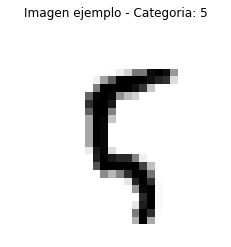

In [6]:
nimagen = 100
plt.imshow(x_train[nimagen, :].reshape(28,28), cmap='gray_r')
plt.title('Imagen ejemplo - Categoria: ' + str(np.argmax(y_train[nimagen])))
plt.axis('off')

Por defecto, Keras requiere cada dato de entrada en el formato nimagenes x nfila x ncolumnas x ncanales, donde ncanales = 1 por ser imagenes en escala de gris. Se debe modificar el tamaño de *x_train* y *x_test* para cumplir con este requerimiento :

In [7]:
x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 3.3 - Creación del modelo

En la siguiente tabla se resumen las características de cada capa a implementar:
    
| **Capa**          | **Características**                            |
|-------------------|------------------------------------------------|
| CONV 1            | 6 filtros, 5x5, p=0, s=1, activación: ReLU     |
| MAX-POOLING 1     | 6 filtros, 2x2, p=0, s=2, activación: Ninguna  |
| CONV 2            | 16 filtros, 5x5, p=0, s=1, activación: ReLU    |
| MAX-POOLING 2     | 16 filtros, 2x2, p=0, s=2, activación: Ninguna |
| FLATTEN           | Simplemente convierte un volumen en un vector  |
| FULLY CONNECTED 1 | 120 neuronas, activación: ReLU                 |
| FULLY CONNECTED 2 | 84 neuronas, activación: ReLU                  |
| SALIDA            | 10 categorías, activación: softmax             |


Creemos el contenedor del modelo usando *Sequential()*:

In [8]:
modelo = Sequential()

Y añadimos, de forma secuencial, la diferentes capas de la red convolucional. En partiular usamos *Conv2D* para las capas convolucionales y *MaxPooling2D* para el *max-pooling*, junto con *Flatten* y *Dense* para la etapa de clasificacion con redes neuronales y la capa de salida :

In [9]:
# CONV 1 y MAX-POOLING 1
modelo.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
modelo.add(MaxPooling2D(pool_size=(2,2)))

# CONV 2 y MAX-POOLING 2
modelo.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu'))
modelo.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar, Fully Connected 1 y Fully Connected 2 y salida
modelo.add(Flatten())
modelo.add(Dense(120, activation='relu'))
modelo.add(Dense(84, activation='relu'))
modelo.add(Dense(nclases, activation='softmax'))

### 3.4 - Compilacion del modelo

En esta etapa definimos el optimizador a usar (gradiente descendente, tasa de aprendizaje = 0.1), asi como la funcion de error (entropia cruzada) y la metrica de desempeño (precision) :

In [10]:
sgd = SGD(lr=0.1)
modelo.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

### 3.5 - Entrenamiento

Realicemos el entrenamiento usando 10 iteraciones, tasa de aprendizaje de 0.1, y un tamaño de lote (*batch_size*) de 128 :

In [11]:
nepochs = 10
tam_lote = 128
modelo.fit(x_train, y_train, epochs=nepochs, batch_size=tam_lote, validation_data=(x_test,y_test), verbose=1)

Epoch 1/10
469/469 [==============================] - 60s 127ms/step - loss: 0.3826 - accuracy: 0.8789 - val_loss: 0.1167 - val_accuracy: 0.9621
Epoch 2/10
469/469 [==============================] - 58s 123ms/step - loss: 0.0947 - accuracy: 0.9696 - val_loss: 0.1013 - val_accuracy: 0.9660
Epoch 3/10
469/469 [==============================] - 57s 122ms/step - loss: 0.0658 - accuracy: 0.9789 - val_loss: 0.0493 - val_accuracy: 0.9842
Epoch 4/10
469/469 [==============================] - 57s 122ms/step - loss: 0.0537 - accuracy: 0.9833 - val_loss: 0.0452 - val_accuracy: 0.9856
Epoch 5/10
469/469 [==============================] - 58s 123ms/step - loss: 0.0435 - accuracy: 0.9860 - val_loss: 0.0476 - val_accuracy: 0.9847
Epoch 6/10
469/469 [==============================] - 58s 124ms/step - loss: 0.0373 - accuracy: 0.9880 - val_loss: 0.0445 - val_accuracy: 0.9859
Epoch 7/10
469/469 [==============================] - 62s 131ms/step - loss: 0.0332 - accuracy: 0.9891 - val_loss: 0.0413 - val_ac

Vemos que en la ultima iteracion, el modelo alcanza una precision de 99.3% para el set de entrenamiento y del 98.6% para el set de validacion. Esta precision nos indica que, en promedio, de cada 100 datos, aproximadamente 1 es clasificado incorrectamente. ¡Nada mal!

## 4 - Desempeño del modelo

La precision obtenida anteriormente es una medida de desempeño global de la red convolucional, pero nos permite verificar si algunos digitos resultan mejor clasificados que otros. Para analizar en detalle este comportamiento, podemos usar la matriz de confusion :

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


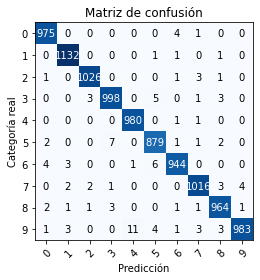

In [12]:
from matriz_confusion import graficar_matriz_de_confusion

y_pred = modelo.predict_classes(x_test)
y_ref = np.argmax(y_test, axis=1) # convertir de one-hot a la representacion numerica original
etiquetas = ['0','1','2','3','4','5','6','7','8','9']
graficar_matriz_de_confusion(y_ref, y_pred, etiquetas)